In [32]:
# Import Library
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

In [33]:
# Transform Data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [34]:
# Load CIFAR10 Dataset 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.524425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7787284].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7085817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7

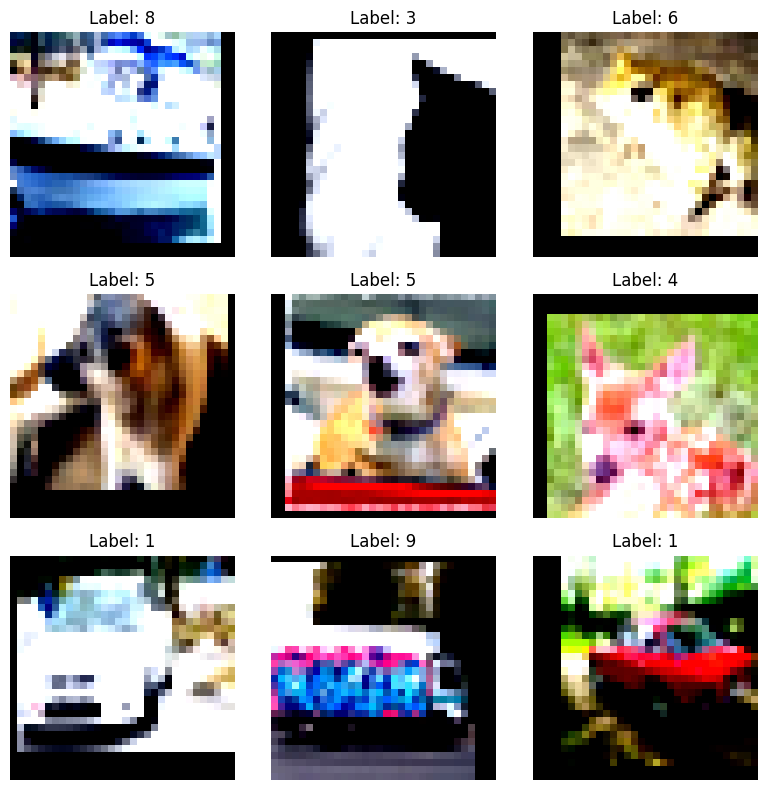

In [35]:
# Pick 9 Random Image from Trainset
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images[:9]
labels = labels[:9]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img = imshow(images[i])
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [36]:
# AlexNet Model
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

In [37]:
# Model, Loss Function, and Optimizer Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
          Dropout-14                 [-

In [39]:
# Training
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass dan optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = total_correct / total_samples
    return train_loss, train_acc

In [40]:
# Testing
def test(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistik
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += targets.size(0)

    test_loss = running_loss / len(testloader)
    test_acc = total_correct / total_samples
    return test_loss, test_acc

In [41]:
# Array for Plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [42]:
# Train and Test Dataset
num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = test(model, testloader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 1/30
Train Loss: 1.7556, Train Accuracy: 0.3329
Test Loss: 1.4898, Test Accuracy: 0.4621
Epoch 2/30
Train Loss: 1.3562, Train Accuracy: 0.5075
Test Loss: 1.2451, Test Accuracy: 0.5560
Epoch 3/30
Train Loss: 1.1769, Train Accuracy: 0.5776
Test Loss: 1.0483, Test Accuracy: 0.6239
Epoch 4/30
Train Loss: 1.0664, Train Accuracy: 0.6204
Test Loss: 0.9798, Test Accuracy: 0.6545
Epoch 5/30
Train Loss: 0.9684, Train Accuracy: 0.6584
Test Loss: 0.8959, Test Accuracy: 0.6879
Epoch 6/30
Train Loss: 0.8937, Train Accuracy: 0.6893
Test Loss: 0.7999, Test Accuracy: 0.7294
Epoch 7/30
Train Loss: 0.8456, Train Accuracy: 0.7052
Test Loss: 0.7765, Test Accuracy: 0.7323
Epoch 8/30
Train Loss: 0.7930, Train Accuracy: 0.7278
Test Loss: 0.7176, Test Accuracy: 0.7527
Epoch 9/30
Train Loss: 0.7612, Train Accuracy: 0.7388
Test Loss: 0.7514, Test Accuracy: 0.7461
Epoch 10/30
Train Loss: 0.7218, Train Accuracy: 0.7520
Test Loss: 0.6890, Test Accuracy: 0.7590
Epoch 11/30
Train Loss: 0.6964, Train Accuracy: 0

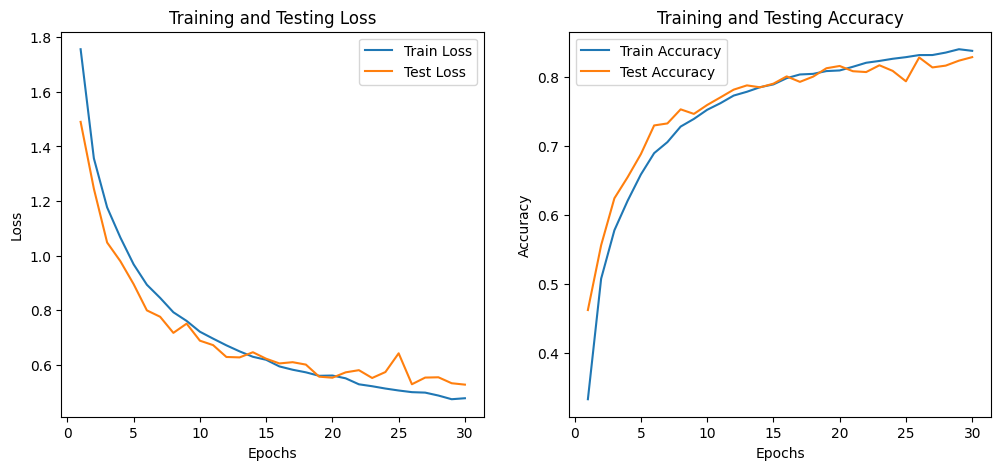

In [44]:
# Loss and Accuracy Plot

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.show()